In [82]:
# pip install xgboost
# !pip install category_encoders

In [43]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb



from sklearn.linear_model import Ridge

from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import PCA

In [44]:
df = pd.read_csv('gurgaon_properties_post_feature_selection_v2.csv')

In [45]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,0.82,3.0,2.0,2,New Property,850.0,0.0,0.0,0.0,Low,Low Floor
1,flat,sector 89,0.95,2.0,2.0,2,New Property,1226.0,1.0,0.0,0.0,Low,Mid Floor
2,flat,sohna road,0.32,2.0,2.0,1,New Property,1000.0,0.0,0.0,0.0,Low,High Floor
3,flat,sector 92,1.60,3.0,4.0,3+,Relatively New,1615.0,1.0,0.0,1.0,High,Mid Floor
4,flat,sector 102,0.48,2.0,2.0,1,Relatively New,582.0,0.0,1.0,0.0,High,Mid Floor


In [46]:
df['furnishing_type'].value_counts()

furnishing_type
0.0    2349
1.0    1018
2.0     187
Name: count, dtype: int64

In [47]:
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished
df['furnishing_type'] = df['furnishing_type'].replace({0.0:'unfurnished',1.0:'semifurnished',2.0:'furnished'})

In [48]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,0.82,3.0,2.0,2,New Property,850.0,0.0,0.0,unfurnished,Low,Low Floor
1,flat,sector 89,0.95,2.0,2.0,2,New Property,1226.0,1.0,0.0,unfurnished,Low,Mid Floor
2,flat,sohna road,0.32,2.0,2.0,1,New Property,1000.0,0.0,0.0,unfurnished,Low,High Floor
3,flat,sector 92,1.60,3.0,4.0,3+,Relatively New,1615.0,1.0,0.0,semifurnished,High,Mid Floor
4,flat,sector 102,0.48,2.0,2.0,1,Relatively New,582.0,0.0,1.0,unfurnished,High,Mid Floor


In [49]:
X = df.drop(columns=['price'])
y = df['price']

In [50]:
# Applying the log1p transformation to the target variable
y_transformed = np.log1p(y)

---


categorical to numerical:
1.Ordinal Encoding
2.OneHotEncoding
3.TargetEncoding


### Ordinal Encoding

Linear Regression does not give good results whereas tree based models give good results.

In [51]:
columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

In [52]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode)
    ], 
    remainder='passthrough'
)

In [53]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [54]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [55]:
scores.mean(),scores.std()

(0.7363096633436828, 0.03238005754429932)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

In [57]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category'])])),
                ('regressor', LinearRegression())])

In [58]:
y_pred = pipeline.predict(X_test)

In [59]:
y_pred = np.expm1(y_pred)

In [60]:
mean_absolute_error(np.expm1(y_test),y_pred)

0.946382216008936

In [61]:
def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
    
    pipeline.fit(X_train,y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output
    

In [62]:
from xgboost import XGBRegressor


In [63]:
model_dict = {
    'linear_reg': LinearRegression(),
    'svr': SVR(),
    'ridge': Ridge(),
    'LASSO': Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest': RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost': XGBRegressor()
}

In [64]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [65]:
model_output

[['linear_reg', 0.7363096633436828, 0.946382216008936],
 ['svr', 0.7642021216646014, 0.8472636473483917],
 ['ridge', 0.7363125343993552, 0.946338774185337],
 ['LASSO', 0.05943378064493573, 1.528905986892753],
 ['decision tree', 0.7782024979414391, 0.7301469179180107],
 ['random forest', 0.8818863017780332, 0.526433069638139],
 ['extra trees', 0.8698156222861477, 0.5519608337582405],
 ['gradient boosting', 0.8726594429242128, 0.576084524067303],
 ['adaboost', 0.7523121130702043, 0.8260591596700628],
 ['mlp', 0.8015818074632252, 0.7220387364617938],
 ['xgboost', 0.8894876835260124, 0.5040475127230885]]

In [66]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [67]:
model_df.sort_values(['mae'])

,name,r2,mae
10,xgboost,0.889488,0.504048
5,random forest,0.881886,0.526433
6,extra trees,0.869816,0.551961
7,gradient boosting,0.872659,0.576085
9,mlp,0.801582,0.722039
4,decision tree,0.778202,0.730147
8,adaboost,0.752312,0.826059
1,svr,0.764202,0.847264
2,ridge,0.736313,0.946339
0,linear_reg,0.736310,0.946382


---


### OneHotEncoding

In [68]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first'),['sector','agePossession','furnishing_type'])
    ], 
    remainder='passthrough'
)

In [69]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [70]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [71]:
scores.mean()

0.8546112792716141

In [72]:
scores.std()

0.01599323234861558

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

In [74]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first'),
                                                  ['sector', 'agePossession',
                                                   'furnishing_type'])])),
                ('regressor', LinearRegression())])

In [75]:
y_pred = pipeline.predict(X_test)

In [76]:
y_pred = np.expm1(y_pred)

In [77]:
mean_absolute_error(np.expm1(y_test),y_pred)

0.6497696680344619

In [78]:
def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
    
    pipeline.fit(X_train,y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output
    

In [79]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [83]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [84]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [85]:
model_df.sort_values(['mae'])

,name,r2,mae
6,extra trees,0.893823,0.469411
10,xgboost,0.895850,0.493456
5,random forest,0.891740,0.503465
9,mlp,0.870529,0.541925
7,gradient boosting,0.876522,0.570773
0,linear_reg,0.854611,0.649770
2,ridge,0.854676,0.652899
4,decision tree,0.806244,0.716613
1,svr,0.769752,0.834124
8,adaboost,0.752290,0.840214


---


### OneHotEncoding With PCA

In [86]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['sector','agePossession'])
    ], 
    remainder='passthrough'
)

In [88]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('regressor', LinearRegression())
])

In [89]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [90]:
scores.mean()

0.06225201431451136

In [91]:
scores.std()

0.019860594071640154

In [92]:
def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=0.95)),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
    
    pipeline.fit(X_train,y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output
    

In [93]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [94]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [95]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [96]:
model_df.sort_values(['mae'])

,name,r2,mae
5,random forest,0.762887,0.654389
6,extra trees,0.739859,0.706134
4,decision tree,0.696442,0.761509
10,xgboost,0.622205,0.967581
7,gradient boosting,0.610623,0.987906
8,adaboost,0.309914,1.350899
1,svr,0.218073,1.361198
9,mlp,0.206165,1.407410
2,ridge,0.062252,1.526707
0,linear_reg,0.062252,1.526707


---

### Target Encoder

In [97]:
import category_encoders as ce

columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['agePossession']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ], 
    remainder='passthrough'
)

In [98]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [99]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [100]:
scores.mean(),scores.std()

(0.829521918225536, 0.018384463379122903)

In [101]:
def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
    
    pipeline.fit(X_train,y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output
    

In [102]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [103]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [104]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [105]:
model_df.sort_values(['mae'])

,name,r2,mae
10,xgboost,0.904798,0.447518
6,extra trees,0.902788,0.457630
5,random forest,0.900790,0.458369
7,gradient boosting,0.889048,0.508792
4,decision tree,0.827006,0.542747
9,mlp,0.854177,0.666829
8,adaboost,0.820280,0.696458
0,linear_reg,0.829522,0.713011
2,ridge,0.829536,0.713523
1,svr,0.782917,0.818851


---


### Hyperparameter Tuning

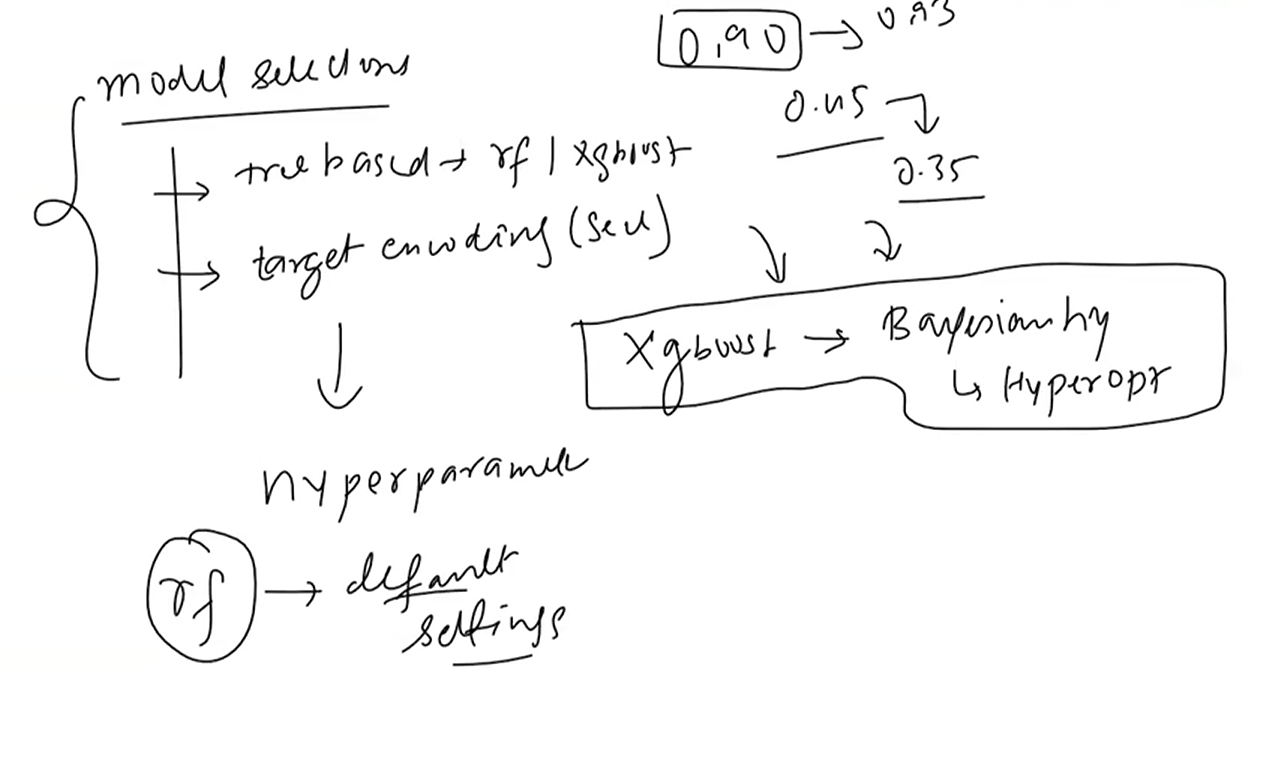

In [106]:
from sklearn.model_selection import GridSearchCV

In [107]:
param_grid = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__max_samples':[0.1, 0.25, 0.5, 1.0],
    'regressor__max_features': ['auto', 'sqrt']
}

In [108]:
columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['agePossession']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ], 
    remainder='passthrough'
)

In [109]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

In [110]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [111]:
search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='r2', n_jobs=-1, verbose=4)

In [112]:
search.fit(X, y_transformed)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=nan total time=   0.1s
[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=nan total time=   0.1s
[CV 10/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=nan total time=   0.1s
[CV 9/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=nan total time=   0.1s
[CV 4/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=nan total time=   0.1s
[CV 2/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=nan total time

/home/mona/project/real-estate/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
640 fits failed out of a total of 1280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
395 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mona/project/real-estate/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mona/project/real-estate/venv/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/mona/project/real-estate/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['bedRoom',
                                                                          'bathroom',
                                                                          'built_up_area',
                                                                          'servant '
                                                                          'room',
                                                                          'store '
                                                                          'room']),
                                                                        ('cat',
                                                                         OrdinalEncoder(),
                                                                         ['property_type',
                                                                          'sector',
                                                                          'balcony',
                                                                          'agePossession',
                                                                          'furnishing_type',...
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['agePossession']),
                                                                        ('target_enc',
                                                                         TargetEncoder(),
                                                                         ['sector'])])),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__max_features': ['auto', 'sqrt'],
                         'regressor__max_samples': [0.1, 0.25, 0.5, 1.0],
                         'regressor__n_estimators': [50, 100, 200, 300]},
             scoring='r2', verbose=4)

In [113]:
final_pipe = search.best_estimator_

In [114]:
search.best_params_

{'regressor__max_depth': 30,
 'regressor__max_features': 'sqrt',
 'regressor__max_samples': 1.0,
 'regressor__n_estimators': 300}

In [115]:
search.best_score_

0.9026618797787392

In [116]:
final_pipe.fit(X,y_transformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['agePossession']),
                                                 ('target_enc', TargetEncoder(),
                                                  ['sector'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=30, max_features='sqrt',
                                       max_samples=1.0, n_estimators=300))])

---


### Exporting the model

In [117]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['sector','agePossession'])
    ], 
    remainder='passthrough'
)

In [118]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=500))
])

In [119]:
pipeline.fit(X,y_transformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['sector',
                                                   'agePossession'])])),
                ('regressor', RandomForestRegressor(n_estimators=500))])

In [120]:
import pickle

with open('pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [121]:
with open('df.pkl', 'wb') as file:
    pickle.dump(X, file)

In [122]:
X

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,3.0,2.0,2,New Property,850.0,0.0,0.0,unfurnished,Low,Low Floor
1,flat,sector 89,2.0,2.0,2,New Property,1226.0,1.0,0.0,unfurnished,Low,Mid Floor
2,flat,sohna road,2.0,2.0,1,New Property,1000.0,0.0,0.0,unfurnished,Low,High Floor
3,flat,sector 92,3.0,4.0,3+,Relatively New,1615.0,1.0,0.0,semifurnished,High,Mid Floor
4,flat,sector 102,2.0,2.0,1,Relatively New,582.0,0.0,1.0,unfurnished,High,Mid Floor
...,...,...,...,...,...,...,...,...,...,...,...,...
3549,flat,sector 84,2.0,2.0,1,Relatively New,532.0,0.0,0.0,unfurnished,Medium,Mid Floor
3550,house,sector 109,5.0,5.0,3+,Relatively New,6228.0,1.0,1.0,unfurnished,High,Low Floor
3551,flat,sector 2,1.0,1.0,1,Moderately Old,665.0,0.0,0.0,semifurnished,Medium,Mid Floor
3552,house,sector 43,5.0,6.0,3,Moderately Old,5490.0,1.0,1.0,unfurnished,Medium,Mid Floor


---


### Trying out the predictions

In [123]:
X.columns

Index(['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furnishing_type', 'luxury_category', 'floor_category'],
      dtype='object')

In [124]:
X.iloc[0].values

array(['flat', 'sector 36', 3.0, 2.0, '2', 'New Property', 850.0, 0.0,
       0.0, 'unfurnished', 'Low', 'Low Floor'], dtype=object)

In [125]:
data = [['house', 'sector 102', 4, 3, '3+', 'New Property', 2750, 0, 0, 'unfurnished', 'Low', 'Low Floor']]
columns = ['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furnishing_type', 'luxury_category', 'floor_category']

# Convert to DataFrame
one_df = pd.DataFrame(data, columns=columns)

one_df


,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,house,sector 102,4,3,3+,New Property,2750,0,0,unfurnished,Low,Low Floor


In [126]:
np.expm1(pipeline.predict(one_df))

array([3.07345109])

In [127]:
X.dtypes

property_type       object
sector              object
bedRoom            float64
bathroom           float64
balcony             object
agePossession       object
built_up_area      float64
servant room       float64
store room         float64
furnishing_type     object
luxury_category     object
floor_category      object
dtype: object

In [128]:
sorted(X['sector'].unique().tolist())

['dwarka expressway',
 'gwal pahari',
 'manesar',
 'sector 1',
 'sector 10',
 'sector 102',
 'sector 103',
 'sector 104',
 'sector 105',
 'sector 106',
 'sector 107',
 'sector 108',
 'sector 109',
 'sector 11',
 'sector 110',
 'sector 111',
 'sector 112',
 'sector 113',
 'sector 12',
 'sector 13',
 'sector 14',
 'sector 15',
 'sector 17',
 'sector 2',
 'sector 21',
 'sector 22',
 'sector 23',
 'sector 24',
 'sector 25',
 'sector 26',
 'sector 27',
 'sector 28',
 'sector 3',
 'sector 30',
 'sector 31',
 'sector 33',
 'sector 36',
 'sector 37',
 'sector 37d',
 'sector 38',
 'sector 39',
 'sector 4',
 'sector 40',
 'sector 41',
 'sector 43',
 'sector 45',
 'sector 46',
 'sector 47',
 'sector 48',
 'sector 49',
 'sector 5',
 'sector 50',
 'sector 51',
 'sector 52',
 'sector 53',
 'sector 54',
 'sector 55',
 'sector 56',
 'sector 57',
 'sector 58',
 'sector 59',
 'sector 6',
 'sector 60',
 'sector 61',
 'sector 62',
 'sector 63',
 'sector 63a',
 'sector 65',
 'sector 66',
 'sector 67',
 'se